## Introduction

A question to consider at the start of a data science exercise is "can this problem be solved by an experienced human?". From a geoscience background, the initial hunch is no. This is also reflected in the moderate scores, no team has over 65% yet. 

We want to define a function y = h(X) 
Where y is originaly based on y = h(U)
Where: h(U) is a geological interpretation of core data and will not be reproducible in this experiment. It is not assured that y can be predicted based only on these well logs.

This evaluation investigated this idea and consider what could be done to allow for a higher score. It followed:

1. Consider if the problem can be answered.
2. Exploratory data analysis.
3. Test a simple model.
4. Select base models based on testing models with different parameters.
5. Engineer extra features and optimize.

#### Conclusions
The results suggest that there is significant overlap in the wireline well log responses for a number of facies. That even with feature engineering it can be difficult to differentiate. It is beyond the scope of this submission to discuss the geological and petrophysical reasons for this. One key example is non-marine coarse siltstone vs. non-marine fine siltstone, this produces the most errors of all models tested. Even in core these two can be challenging to interpret. Perhaps gouping into one non-marine siltstone would be more suitable for a modelling exercise.

The learning curves and other QC plots do not seem to suggest that obtaining more data will neccisarily make this better as they all flatten out early. The main problem here is recall. Either the question should be reconfigured to ask for rock property groups that can be defined by a petrophyist or a greater variety of well logs should be used. E.g. spectral gamma ray.

A score around 90-95% may be needed to give confidence to be implemented in a producing field. The conclusions for this evaluation is that the experimental design needs to changed to be able to achieve this. This competition and the original paper has been a fantastic way to start a discussion within the geoscience community around machine learning, the lower scores appear to be a limitation of this specific challenge rather than the machine learning methodlogies.

##### Initializing

In [2]:
#     Initializing

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import seaborn as sns

#Enable inline plotting
%matplotlib inline

print ("This has been run using:")
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

## Set colour template
sns.set(style="ticks")    ## Set style to white background and ticks
sns.set_context("paper")   ## Set size of labels

This has been run using:
Python version 3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
Pandas version 0.19.1
Matplotlib version 1.5.3


In [176]:
#     Load file
try:
    print("Loading dataset...")
    CSV_Dataset = r"facies_vectors.csv"
    Dataset = pd.read_csv(CSV_Dataset)
except:
    print ("An error has occured")
    print ("Please ensure that you have downloaded the dataset and")
    print ("entered the file location and file path for your machine")
finally:
    print ("Expected input is the file facies_vectors.csv")

Dataset.head()

Loading dataset...
Expected input is the file facies_vectors.csv


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


## Step 2: Checking the data

['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE'
 'NOLAN' 'Recruit F9' 'NEWBY' 'CHURCHMAN BIBLE']


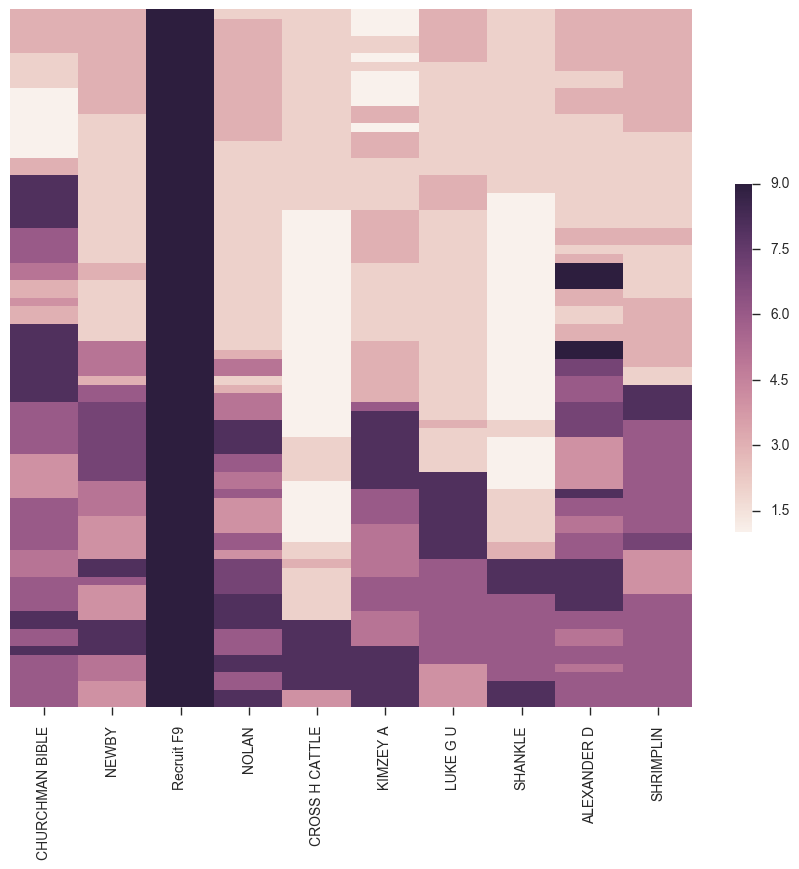

In [177]:
#### Make a new array  that consists of the facies organised in columns for each well
Facies_Plot = Dataset.iloc[:,0]
Well = Dataset.iloc[:,2]
Facies_Plot = pd.concat([Facies_Plot, Well], axis=1)
grouped = Facies_Plot.groupby('Well Name')
Facies_Plot = Facies_Plot.rename(columns = {"Well Name":"Well_Name"}) # To be able to use the header in the .unique method
List = Facies_Plot.Well_Name.unique()
print (List)
u = np.arange(501)  #make a dummy key based on the legth of the longest well - Should be automated.
b = pd.DataFrame()
b["key"]=u
for i in List:
    a = grouped.get_group(i)
    a = a.rename(columns = {"Facies":i})
    a = a.drop("Well Name", 1)
    [c, d] = a.shape
    e = np.arange(c)
    a["key"]=e
    #b = pd.concat([a, b], axis=1)
    b = pd.merge(a, b, on='key')
Facies_Plot = b
Facies_Plot = Facies_Plot.drop("key", 1)

## Plot all facies to give a visual impression of the distribution of facies
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(Facies_Plot, yticklabels=False, linewidths=0, vmin=1, vmax=9, ax=ax, cbar_kws={"shrink": .5})


The heatmap above gives a quick visual feeling of the distrbution of facies. There is an uneven distribution to the presence of facies and skewes in the relative proporiton of facies both in total count and across individual well bores. Individual well bores can contain quite differnt distributions of facies. THere appears to be some systematic relationship with depth.

###### Investigate PE

By plotting all PE values in all wellbores we can see that the missing values appear to sit in two gaps.
Here Non-marine to marine ratio is used to demonstrate a conintous data set including all the 4149 values.
It can be seen that marine to non marine is a binary input but set to 1s and 2s. 

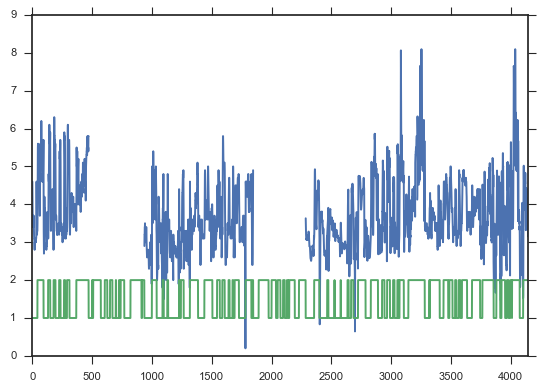

In [5]:
Dataset['PE'].plot()
Dataset['NM_M'].plot()

##### Replace all missing values with mean

In [178]:
## Replace all missing values with the mean values
Dataset = Dataset.fillna(Dataset.mean())

## Step 3: Tidying the data

###### Create new results categories

Make new categories to clump together associated facies

In [179]:
### Create new categories

ytemp= Dataset.iloc[:,0]

def create_category(facies_names, y):
    a = 1
    for i in facies_names:
        y = y.replace(to_replace=a,value=i)
        a+=1
    return y

##Relable numerics with String label
ytemp_1=ytemp
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']

ytemp_1=create_category(facies_names, ytemp_1)

## Make a new column of depositional environments
ytemp_2=ytemp    
ytemp_2 = ytemp_2.rename(columns = {"Facies":"Dep Environment"})
facies_names = ['Clastic Non-marine', 'Clastic Non-marine', 'Clastic Non-marine', 'Clastic Non-marine', 'Clastic Marine', 'Carb Platform', 'Carb Platform', 'Carb Platform', 'Carb Platform']

ytemp_2=create_category(facies_names, ytemp_2)


## Make a new column of clastic vs. carbonate
ytemp_3=ytemp
ytemp_3.rename(columns={"Facies":"Lithology"}, inplace=True)
facies_names = ['Clastic', 'Clastic', 'Clastic', 'Clastic', 'Clastic', 'Carb', 'Carb', 'Carb', 'Carb']

ytemp_3=create_category(facies_names, ytemp_3)
    
## Make a new column of non-marine vs. marine
ytemp_4=ytemp
ytemp_4.rename(columns={"Facies":"Marine vs Non-marine"}, inplace=True)
facies_names = ['Non-marine', 'Non-marine', 'Non-marine', 'Marine', 'Marine', 'Marine', 'Marine', 'Marine', 'Marine']

ytemp_4=create_category(facies_names, ytemp_4)

## Merge the results into a new table
ytemp = pd.concat([ytemp_1, ytemp_2, ytemp_3, ytemp_4], axis=1)
ytemp.rename(columns={0:"Dep Environment"}, inplace=True)
ytemp.rename(columns={1:"Lithology"}, inplace=True)
ytemp.rename(columns={2:"M vs NM"}, inplace=True)
print(ytemp.head())
print(ytemp.tail())
new_classes = ytemp

  Facies     Dep Environment Lithology     M vs NM
0   FSiS  Clastic Non-marine   Clastic  Non-marine
1   FSiS  Clastic Non-marine   Clastic  Non-marine
2   FSiS  Clastic Non-marine   Clastic  Non-marine
3   FSiS  Clastic Non-marine   Clastic  Non-marine
4   FSiS  Clastic Non-marine   Clastic  Non-marine
     Facies Dep Environment Lithology M vs NM
4144     MS  Clastic Marine   Clastic  Marine
4145     MS  Clastic Marine   Clastic  Marine
4146     MS  Clastic Marine   Clastic  Marine
4147     MS  Clastic Marine   Clastic  Marine
4148     MS  Clastic Marine   Clastic  Marine


###### Create y

A template for the size of a y array will be created.

After seperating y the numeric code will be changed to a one-hot vector.
So, 3 will = 001000000. Note that as indecies begin at 0 this will make the index for value 3, be a position 2.

One hot encoding takes categorical features to a format that can work better for classification algorithms.

In [180]:
ytemp = Dataset.iloc[:,0] #Note 0 index is used in python for the first position. 
print (("m={0}").format(ytemp.shape))

## Keep the original version where all classifiers are stored in one columnn
y_one_column = ytemp


## Get all the elements of y
ySet = set(ytemp)
Yn = len(ySet)
print (("K={0}").format(Yn))

# One hot vector for each valye of y.
# Each classifier should have a sperate column and be measured only in ones and zeros
one_hot_y = ytemp
y = pd.get_dummies(one_hot_y)

y = y.rename(columns={1: "NM Coarse Sandstone", 2: "NM Coarse Siltstone", 3: "NM Fine Siltstone", 4:"Marine Siltstone", 5:"Mud Stone", 6:"Wacke Stone", 7:"Dolomite", 8:"Packe Stone", 9:"Baffle Stone"})

m=(4149,)
K=9


###### Create X

Remove the y(facies) from the dataset to create X. The training data. 

In [182]:
[Dm , Dn] = Dataset.shape
print (Dm)
print (Dn)
X = Dataset.iloc[:,1:Dn]  #where Dn is the number of columns in the original dataset

## List which features should be dropped from the training data
Dropped_Features = ["Formation"]

X = X.drop(Dropped_Features, 1)
print (X.head())
[Xm , Xn] = X.shape

4149
11
   Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND   PE  NM_M  RELPOS
0  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915  4.6     1   1.000
1  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565  4.1     1   0.979
2  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050  3.6     1   0.957
3  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115  3.5     1   0.936
4  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300  3.4     1   0.915


#### Remerge data into new dataframe

In [172]:
## Merge together new class labels, y results as one hot vecotr and X
df_full = pd.concat([new_classes, y, X], axis=1)
df = pd.concat([new_classes, X], axis=1)

## Exploratory Analysis
A few key observations are presented.

In [160]:
### Set some colour parameters.
cmap_facies = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
cmap_m_nm = ["sage", "royalblue"]
cmap_clas_carb = ["gold", "slategrey"]

### Non-marine vs. marine
Using the new simplified classification based on grouping facies as Non-marin or marine it can be seen that the well top defined marine vs. non-marine indicator seems to contradict core based facies descriptions. Even so, facies 1, 7, and 9 have a powerful relationship to this parameter. This is likely the result of NM_M feature being based on the geological interpretation of well tops rather than being a raw piece of data, there is also ambiguity in the interpretation of facies from core but this is typically more of a trusted source than geological well tops interpretations only based on logs. The cauase can only be speculated there is an issue with the data.

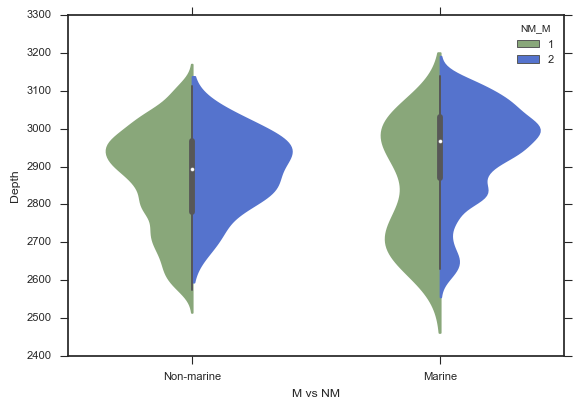

In [161]:
sns.violinplot(x="M vs NM", y="Depth", hue="NM_M", data=df,
               split=True, palette=cmap_m_nm)

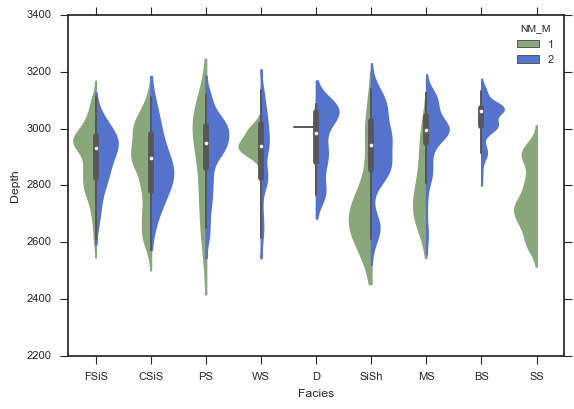

In [162]:
sns.violinplot(x="Facies", y="Depth", hue="NM_M", data=df,
               split=True, palette=cmap_m_nm)

### Carbonates vs. Clastics
One example pair of plots that appears to differntiate some features is PE vs. PHIND.
Where PE appears to help emphasise some of the carbonate environments. 

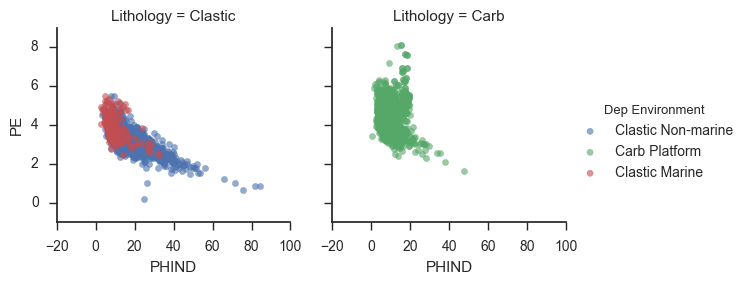

In [164]:
sns.set(style="ticks")
Crossplot = sns.FacetGrid(df, col="Lithology", hue="Dep Environment")
Crossplot.map(plt.scatter, "PHIND", "PE", alpha=.6,)
Crossplot.add_legend()

#### Individual facies
Each indvidual facies can be plotted to see if there are any that are more isolated and any that heavily overlap

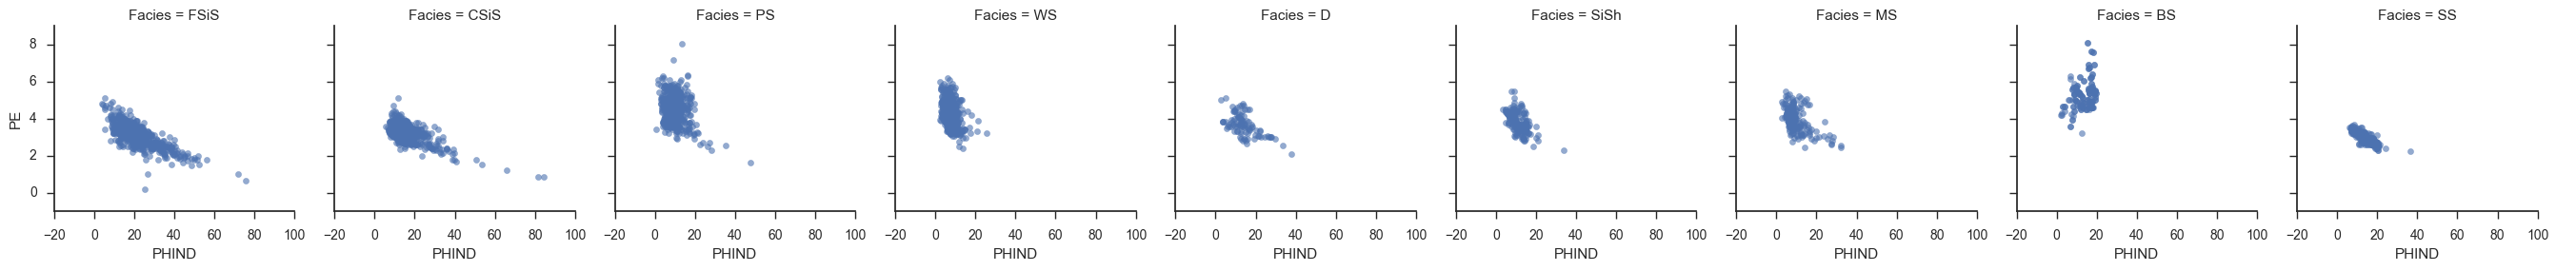

In [165]:
sns.set(style="ticks")
Crossplot = sns.FacetGrid(df, col="Facies")
Crossplot.map(plt.scatter, "PHIND", "PE", alpha=.6,)
Crossplot.add_legend()

### Principal Component Analysis
Pincipal component analysis can be applied to the data in attempt to visualise it onto fewer dimensions.
The concept here is that dimensionality could be reduced and the data then projected onto the linear subspace spanned by K vectors. Where K is the number of principal components choose.

This in effect could investigate for bulk lithology, pore fluid fill or if there are key controllers, although it can be challenging to know exactly what the new dimensions will represent without further investigations.

The first step is to just investigate the dataset to see if the method could prove valuable with such a small selection of logs. The below will take 5 of the logs and see if there are any ways to maintain 99% or 95% of the explained variance from the datasets while reducing the dimensionality.

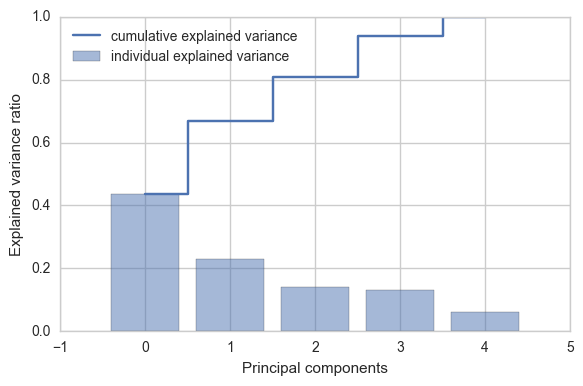

In [183]:
# Drop well name and binary features
drop = ["Well Name", "NM_M", "Depth", "RELPOS"]
X_temp = X.drop(drop, 1)

# Data should be preprocessed using mean normalisation before input to principal component analysis. 
# After mean normalization each parameter should have zero mean. (mean=0 and variance=1).
from sklearn.preprocessing import normalize, StandardScaler, RobustScaler
#X_Scaler = StandardScaler()
X_Scaler = RobustScaler()
X_Scaled = X_Scaler.fit_transform(X_temp)

# Project onto the linear subspace spanned by k number of vectors.
K = 5 # K is called number of n_components in Sci Kit learn.
from sklearn.decomposition import PCA, IncrementalPCA
ipca = IncrementalPCA(n_components=K, batch_size=10)
X_ipca = ipca.fit_transform(X_Scaled)

# Choose K by looking to retain 99% (0.01) of variance. K should be the smallest value that will give a 99% variance.
# There can be some variations for example 95% (0.05).
cum_var_exp = np.cumsum(ipca.explained_variance_ratio_)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range((ipca.n_components_)), ipca.explained_variance_ratio_, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(ipca.n_components_), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

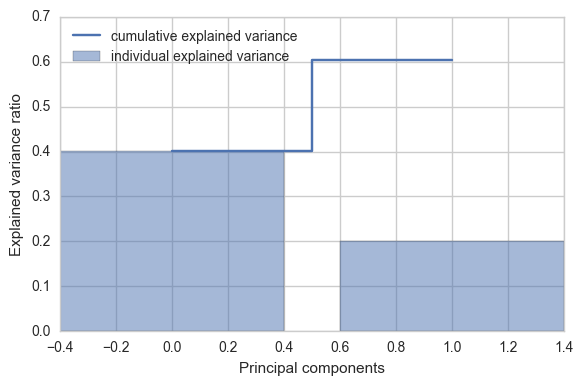

In [184]:
# Drop well name and binary features
drop = ["Well Name", "NM_M", "Depth"]
X_temp = X
X_temp = X.drop(drop, 1)

# Data should be preprocessed using mean normalisation before input to principal component analysis. 
# After mean normalization each parameter should have zero mean. (mean=0 and variance=1).
from sklearn.preprocessing import normalize, StandardScaler, RobustScaler
#X_Scaler = StandardScaler()
X_Scaler = RobustScaler()
X_Scaled = X_Scaler.fit_transform(X_temp)

# Project onto the linear subspace spanned by k number of vectors.
K = 2 # K is called number of n_components in Sci Kit learn.
from sklearn.decomposition import PCA, IncrementalPCA
ipca = IncrementalPCA(n_components=K, batch_size=10)
X_ipca_K2 = ipca.fit_transform(X_Scaled)

# Choose K by looking to retain 99% (0.01) of variance. K should be the smallest value that will give a 99% variance.
# There can be some variations for example 95% (0.05).
cum_var_exp = np.cumsum(ipca.explained_variance_ratio_)
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range((ipca.n_components_)), ipca.explained_variance_ratio_, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(ipca.n_components_), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

Even though the pricipal compnent analysis does not appear to be able to maintain the a high enough variance figures can be plotted when K=2 to investigate how the classifiers appear. If there is significant overlap or if there are discreet groups.

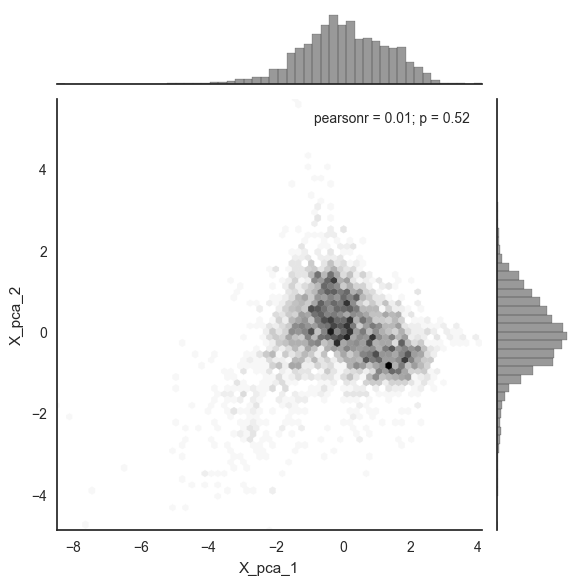

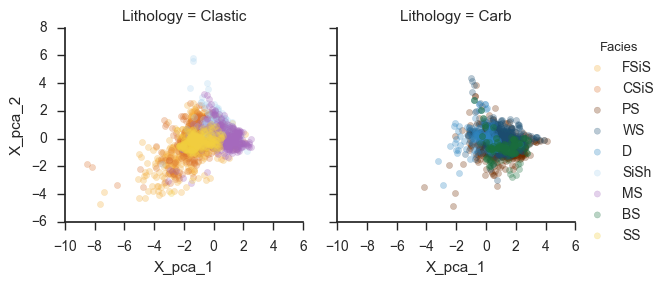

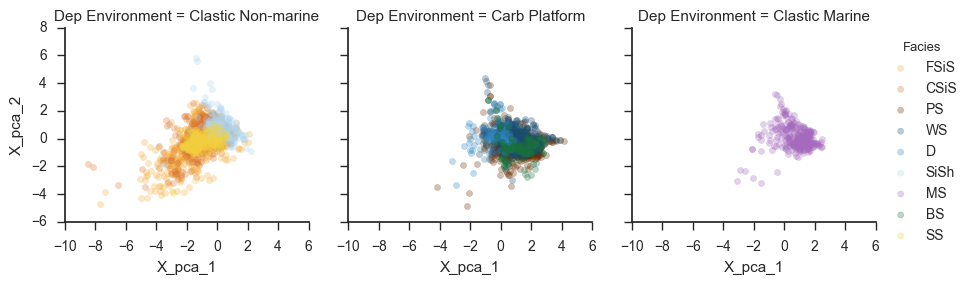

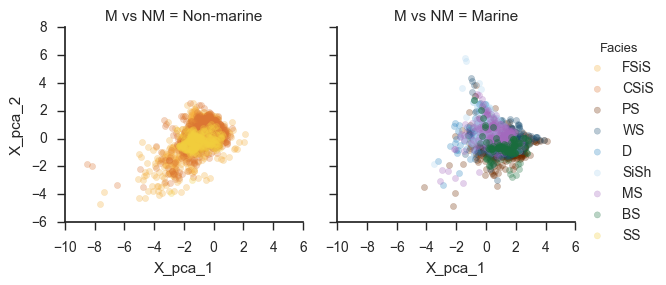

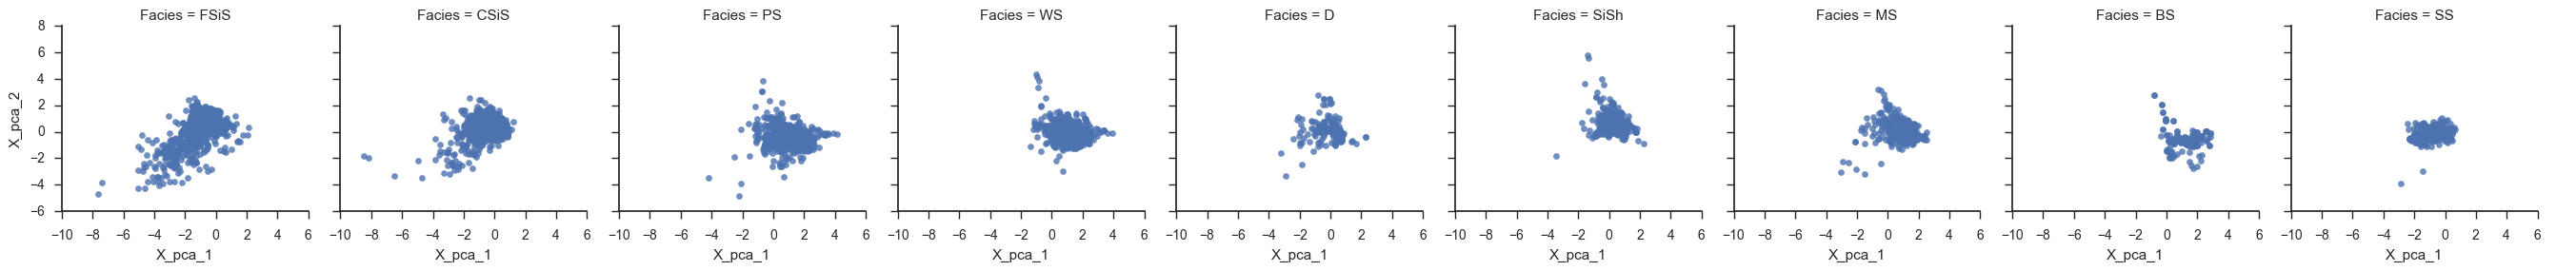

In [185]:
## Make a data frame using the 2 dimensional result from principal component analysis
df_ipca = pd.DataFrame(X_ipca_K2, columns=["X_pca_1", "X_pca_2"])
df_ipca = df = pd.concat([new_classes, df_ipca], axis=1)
with sns.axes_style("white"):
    sns.jointplot(x="X_pca_1", y="X_pca_2", data=df_ipca, kind="hex", color="k");
sns.set(style="ticks")

facies_colors = ['#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D', '#F4D03F']
cmap=facies_colors
pal_facies=sns.color_palette(cmap)
Lithology_pca = sns.FacetGrid(df_ipca, col="Lithology", palette=pal_facies, hue="Facies")
Lithology_pca.map(plt.scatter, "X_pca_1", "X_pca_2", alpha=.3)
Lithology_pca.add_legend();

Dep__Env_pca = sns.FacetGrid(df_ipca, col="Dep Environment", palette=pal_facies, hue="Facies")
Dep__Env_pca.map(plt.scatter, "X_pca_1", "X_pca_2", alpha=.3)
Dep__Env_pca.add_legend();

NM_M_pca = sns.FacetGrid(df_ipca, col="M vs NM", palette=pal_facies, hue="Facies")
NM_M_pca.map(plt.scatter, "X_pca_1", "X_pca_2", alpha=.3)
NM_M_pca.add_legend();

Facies = sns.FacetGrid(df_ipca, col="Facies", palette=pal_facies)
Facies.map(plt.scatter, "X_pca_1", "X_pca_2", alpha=.8)
Facies.add_legend();

By projecting all the log data onto only 2 dimensions it can now be plotted against facies and with different catgories. As the explained variance is only 64% we have lost 36% of the variance created by other features. This is highlighted by the hexagonal plot which shows that the data is clustered into the center. Even so these plots help investigate if there are any trends to be observed between groups of facies. The main observation is there is significant overlap between a range of difference classifiers (facies).

FSiS and CSis appear to overlap significantly.
PS and WS appear to overlap significantly with MS also appear to cover some of the similar areas.
BS appears to overlap with the above 3, it also appears that perhaps it is difficult to discern key trends from this data due to low number of samples.
SS shows one of the most distinctive groupings.
SS being in the center without much variance may indicate that it relates to this element having lost its variance through the PCA process. 

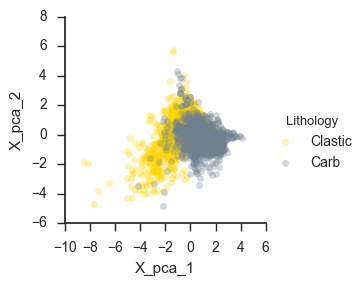

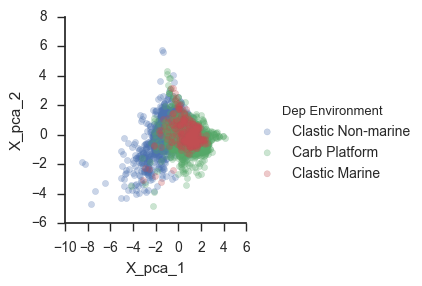

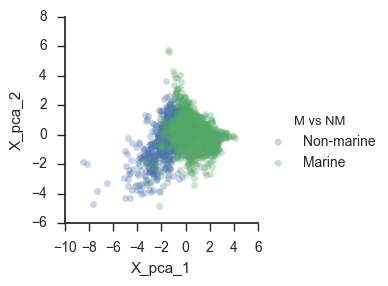

In [186]:
V1_pca = sns.FacetGrid(df_ipca, hue="Lithology", palette=cmap_clas_carb)
V1_pca.map(plt.scatter, "X_pca_1", "X_pca_2", alpha=.3)
V1_pca.add_legend();

V2_pca = sns.FacetGrid(df_ipca, hue="Dep Environment")
V2_pca.map(plt.scatter, "X_pca_1", "X_pca_2", alpha=.3)
V2_pca.add_legend();

V3_pca = sns.FacetGrid(df_ipca, hue="M vs NM")
V3_pca.map(plt.scatter, "X_pca_1", "X_pca_2", alpha=.3)
V3_pca.add_legend();

When plotting the newly created classifiers it is simpler to see trends emerging suggesting these classifiers will be easier to discriminate than the individual facies classifiers.

The two attempts above show that it is difficult to maintain variance in the dataset while reducing the dimensionality. The heatmap shows the results for all potential values of K. No result will maintina 99% or 95% variance.

                  Cumalative explained variance
[[ 0.3971977   0.          0.          0.          0.        ]
 [ 0.40137025  0.60337192  0.          0.          0.        ]
 [ 0.40284999  0.60887752  0.73435243  0.          0.        ]
 [ 0.40411421  0.61467155  0.74730067  0.8358001   0.        ]
 [ 0.40442674  0.61574404  0.74887028  0.86727773  0.94078121]]


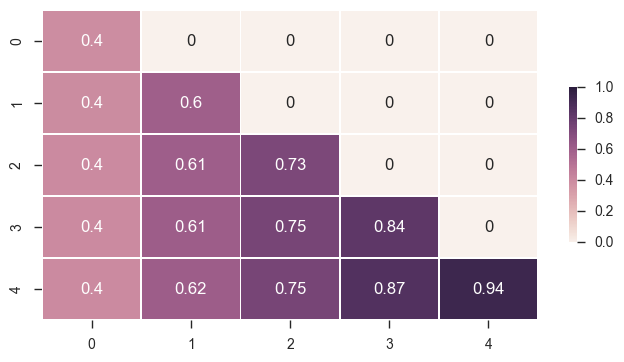

In [187]:
## Make a heatmap showing cumalative variance with change number of K vectors.

# Drop well name and binary features
drop = ["Well Name", "NM_M", "Depth"]
X_temp = X
X_temp = X.drop(drop, 1)

# Data should be preprocessed using mean normalisation before input to principal component analysis. 
# After mean normalization each parameter should have zero mean. (mean=0 and variance=1).
from sklearn.preprocessing import normalize, StandardScaler, RobustScaler
#X_Scaler = StandardScaler()
X_Scaler = RobustScaler()
X_Scaled = X_Scaler.fit_transform(X_temp)

# Project onto the linear subspace spanned by k number of vectors.
K = 5 # K is called number of n_components in Sci Kit learn.
a=[]
from sklearn.decomposition import PCA, IncrementalPCA
for i in range(1, K+1):
    ipca = IncrementalPCA(n_components=i, batch_size=10)
    X_ipca = ipca.fit_transform(X_Scaled)
    cum_var_exp = np.cumsum(ipca.explained_variance_ratio_)
    [b, ] = cum_var_exp.shape
    c = np.zeros(((K-b), ))
    cum_var_exp = np.append(cum_var_exp, c)
    a = np.append(a, cum_var_exp)
# Reshape into a K*K matrix
a = np.reshape(a,(K,K))
print("                  Cumalative explained variance")
print (a)

## Set up plot size
f, ax = plt.subplots(figsize=(8, 4))
# Generate a mask for the upper triangle
mask = np.zeros_like(a, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
## Plot heat map 
pca_heat_map = sns.heatmap(a, linewidths=0.5, vmin=0, vmax=1, annot=True, ax=ax, cbar_kws={"shrink": .5})

## First pass classification and review

Split the wells up to experiment with different groups of training and validation sets

In [198]:
from sklearn.model_selection import LeavePGroupsOut
Num_Wells=2
X_matrix=X.values
y_matrix=y.values
groups=X["Well Name"]
Leave_Wells_Out=LeavePGroupsOut(n_groups=Num_Wells)
Splits=Leave_Wells_Out.get_n_splits(X, y, groups)
print("Data is split into %d splits for training and cross-validation" % Splits)
## Make dictionaries
X_train_dict=dict()
X_test_dict=dict()
y_train_dict=dict()
y_test_dict=dict()
List_Train_Wells = dict()
List_Test_Wells = dict()
a = 1
for train_index, test_index in Leave_Wells_Out.split(X, y, groups):
    X_train, X_test = X_matrix[train_index], X_matrix[test_index]
    y_train, y_test = y_matrix[train_index], y_matrix[test_index]
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    X_train = X_train.rename(columns = {0:"Well_Name"})
    X_test = X_test.rename(columns = {0:"Well_Name"})
    List1 = X_train.Well_Name.unique()
    List2 = X_test.Well_Name.unique()
    List_Train_Wells["W_Tr_"+(str(a))] = List1
    List_Test_Wells["W_Ts_"+(str(a))] = List2
    X_train = X_train.drop("Well_Name", 1)
    X_test = X_test.drop("Well_Name", 1)
    X_train=X_train.values
    X_test=X_test.values
    X_train_dict["W_Tr_"+(str(a))] = X_train
    X_test_dict["W_Ts_"+(str(a))] = X_test
    y_train_dict["W_Tr_"+(str(a))] = y_train
    y_test_dict["W_Ts_"+(str(a))] = y_test
    a += 1

Data is split into 45 splits for training and cross-validation


 A learning curve can be created to try and identify the problem.

In [199]:
#### Multi-class learning Curve

C = 0.5
[b, d] = y_tr.shape
print(y_tr.shape)
a = np.zeros(d)
max_iters = 70
m = np.arange(20, max_iters, 1) # Minimum is not set to one as that causes erros when calculating F1 score close to 0
print("Maximum number of training examples is ", max_iters)
train_curve_f1 = [a]   # Array
train_curve_f1_weighted_av = [0] # List
test_curve_f1 = [a]   # Array
test_curve_f1_weighted_av = [0]  # List
for i in m:
    # Set classifier
    clf = OneVsRestClassifier(LogisticRegression(C=C, solver="lbfgs", max_iter=i))
    #clf=RandomForestClassifier()
    clf.fit(X_tr, y_tr)
    # Predict training and cross validation datasets
    p_y_tr = clf.predict(X_tr)
    p_y_ts = clf.predict(X_ts)
    ## Calculate and store scores
    f1score = f1_score(y_tr, p_y_tr, average=None)
    #train_curve_f1 = np.append(train_curve_f1, f1score, axis=0)
    train_curve_f1.append(f1score)
    f1score_av = f1_score(y_tr, p_y_tr, average="weighted")
    train_curve_f1_weighted_av.append(f1score_av)
    f1score = f1_score(y_ts, p_y_ts, average=None)
    #test_curve_f1 = np.append(test_curve_f1, f1score, axis=0)
    test_curve_f1.append(f1score)
    f1score_av = f1_score(y_ts, p_y_ts, average="weighted")
    test_curve_f1_weighted_av.append(f1score_av)
    print ("Iteration %d complete" % i)

##
train_curve_av=pd.DataFrame(train_curve_f1_weighted_av, columns=["F1_w_av_train"])
test_curve_av=pd.DataFrame(test_curve_f1_weighted_av, columns=["F1_w_av_test"])

##### Deal with the multi-class score measures
## Combine the results into a dataframe
train_curve_f1=np.concatenate(train_curve_f1, axis=0 )
test_curve_f1=np.concatenate(test_curve_f1, axis=0 )

## Make a range of column names
def Name_splits(d, name1):
    List = []
    for i in range(1,d+1):
        Name = name1+"Facies_"+str(i)
        List.append(Name)
    return List

## Prepare training curve
curve_name=train_curve_f1 
name1="tr_"
x = curve_name
#### Split the list up
curve_name = [x[i:i+d] for i in range(0, len(x), d)]
List = Name_splits(d, name1)

train_curve_f1=pd.DataFrame(curve_name, columns=List)

## Prepare test curve
curve_name=test_curve_f1
name1="ts_"
x = curve_name
#### Split the list up
curve_name = [x[i:i+d] for i in range(0, len(x), d)]
List = Name_splits(d, name1)

test_curve_f1=pd.DataFrame(curve_name, columns=List)

# Recalculate the number of training examples
#[b, a] = df_LC_test_curve_f1.shape # may be different from max number of iters becuase with some scores it seems to stop zeros being added
#m = np.arange(0, b, 1)

# make a list of curves
curve_list = [train_curve_f1, test_curve_f1, test_curve_av, train_curve_av]
# append m, the number of training examples to each curve
def add_m (curve_list):
    for curve in curve_list:
        [b, a] = curve.shape
        m = np.arange(0, b, 1)
        curve["m"]=m
        
add_m(curve_list)
#print (train_curve_av)

(3229, 9)
Maximum number of training examples is  70
Iteration 20 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 21 complete
Iteration 22 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 23 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 24 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 25 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 26 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 27 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 28 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 29 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 30 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 31 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 32 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 33 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 34 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 35 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 36 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 37 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 38 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 39 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 40 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 41 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 42 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 43 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 44 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 45 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 46 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 47 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 48 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 49 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 50 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 51 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 52 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 53 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 54 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 55 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 56 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 57 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 58 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 59 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 60 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 61 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 62 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 63 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 64 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 65 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 66 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 67 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 68 complete
Iteration 69 complete


/Users/adammccarthy/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Learning curve
A learning curve can give information if the model has high bias or is overfitting. The tricky thing here is it has not converged but nor does it seem to be slowly merging which would may suggest more data will aid in it´s convergence.

When attempting higher order polynomials the traning curve just continues to go up while the cross validation curve stays flat suggesting that higher order polynomials are just overfitting the data.

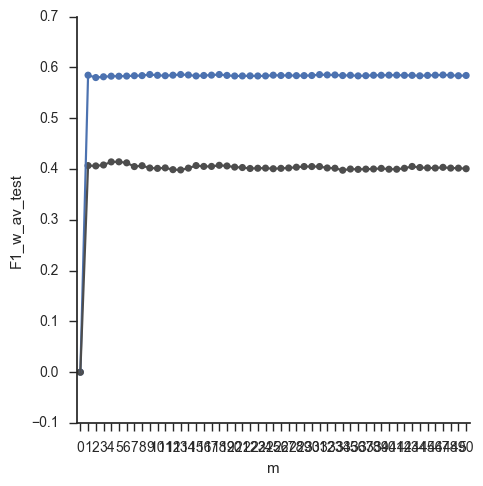

In [193]:
## Learning curve for the weighted average f1 scores. Would be better to display cost function instead of score
train_curve_av["F1_w_av_test"]=test_curve_av["F1_w_av_test"]
plot = sns.factorplot(x="m", y="F1_w_av_train", data=train_curve_av, size=5, scale = 0.5);
plot.map(sns.pointplot, "m", "F1_w_av_test", data=train_curve_av, color="0.3", scale = 0.5);

Breaking down the learning curves into individual facies appears to show that the first two facies are having the hardest time to succesfully train. Mud stone is also struggling but this may better reflect a low number of samples (skewed class).

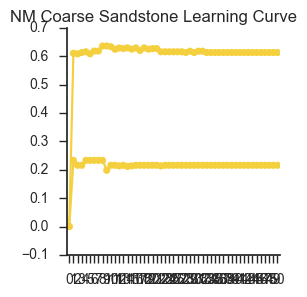

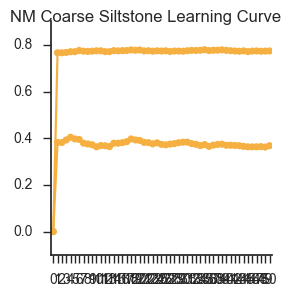

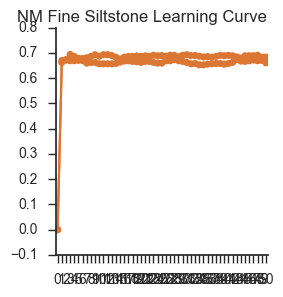

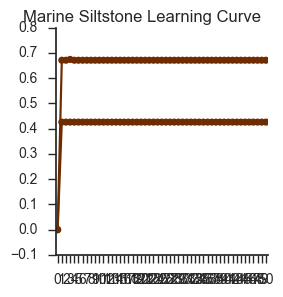

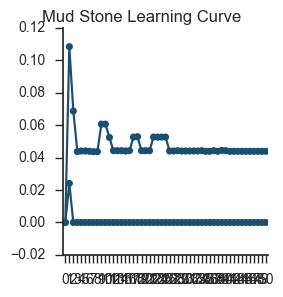

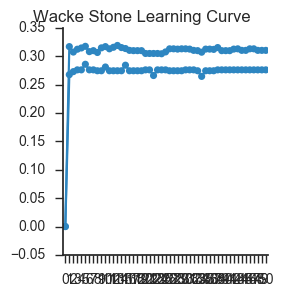

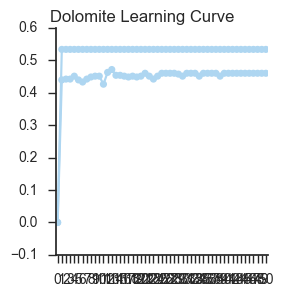

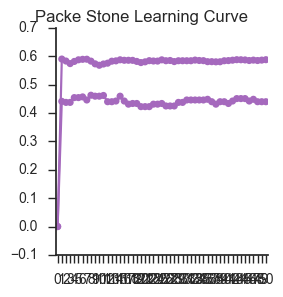

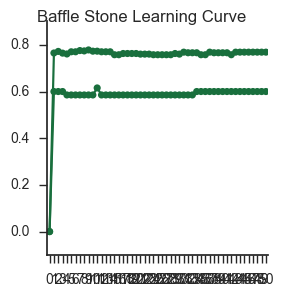

In [194]:
facies_colors = ['#F4D03F','#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
LC1 = sns.factorplot(x="m", y="tr_Facies_1", data=train_curve_f1, color='#F4D03F', size=3, scale = 0.5)
LC1.map(sns.pointplot, x="m", y="ts_Facies_1", data=test_curve_f1, color='#F4D03F', scale = 0.5)
LC1.fig.suptitle('NM Coarse Sandstone Learning Curve')

LC2 = sns.factorplot(x="m", y="tr_Facies_2", data=train_curve_f1, color='#F5B041', size=3, scale = 0.5)
LC2.map(sns.pointplot, x="m", y="ts_Facies_2", data=test_curve_f1, color='#F5B041', scale = 0.5)
LC2.fig.suptitle('NM Coarse Siltstone Learning Curve')

LC3 = sns.factorplot(x="m", y="tr_Facies_3", data=train_curve_f1, color='#DC7633', size=3, scale = 0.5)
LC3.map(sns.pointplot, x="m", y="ts_Facies_3", data=test_curve_f1, color='#DC7633', scale = 0.5)
LC3.fig.suptitle('NM Fine Siltstone Learning Curve')

LC4 = sns.factorplot(x="m", y="tr_Facies_4", data=train_curve_f1, color='#6E2C00', size=3, scale = 0.5)
LC4.map(sns.pointplot, x="m", y="ts_Facies_4", data=test_curve_f1, color='#6E2C00', scale = 0.5)
LC4.fig.suptitle("Marine Siltstone Learning Curve")

LC5 = sns.factorplot(x="m", y="tr_Facies_5", data=train_curve_f1, color='#1B4F72', size=3, scale = 0.5)
LC5.map(sns.pointplot, x="m", y="ts_Facies_5", data=test_curve_f1, color='#1B4F72', scale = 0.5)
LC5.fig.suptitle("Mud Stone Learning Curve")

LC6 = sns.factorplot(x="m", y="tr_Facies_6", data=train_curve_f1, color='#2E86C1', size=3, scale = 0.5)
LC6.map(sns.pointplot, x="m", y="ts_Facies_6", data=test_curve_f1, color='#2E86C1', scale = 0.5)
LC6.fig.suptitle("Wacke Stone Learning Curve")

LC7 = sns.factorplot(x="m", y="tr_Facies_7", data=train_curve_f1, color='#AED6F1', size=3, scale = 0.5)
LC7.map(sns.pointplot, x="m", y="ts_Facies_7", data=test_curve_f1, color='#AED6F1', scale = 0.5)
LC7.fig.suptitle("Dolomite Learning Curve")

LC8 = sns.factorplot(x="m", y="tr_Facies_8", data=train_curve_f1, color='#A569BD', size=3, scale = 0.5)
LC8.map(sns.pointplot, x="m", y="ts_Facies_8", data=test_curve_f1, color='#A569BD', scale = 0.5)
LC8.fig.suptitle("Packe Stone Learning Curve")

LC9 = sns.factorplot(x="m", y="tr_Facies_9", data=train_curve_f1, color='#196F3D', size=3, scale = 0.5)
LC9.map(sns.pointplot, x="m", y="ts_Facies_9", data=test_curve_f1, color='#196F3D', scale = 0.5)
LC9.fig.suptitle("Baffle Stone Learning Curve")

### Reciever operating characteristics 
Reciever operating characteristics will help understand if any of the facies are generating too many false positives. The main issue is coars siltstone.

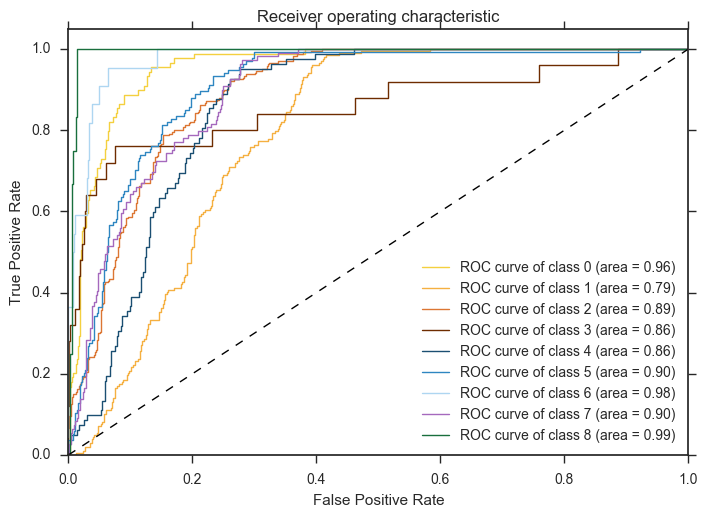

In [196]:
### Plot multi-class ROC curve
from sklearn.metrics import roc_curve, auc

n_classes = y.shape[1]
y_score = clf.decision_function(X_ts)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_ts[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_ts.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

lw = 1
## Multi-class ROC curve    ### Taken from SciKit Learn
from itertools import cycle
plt.figure()
colors = cycle(['#F4D03F','#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall 
Another plot is precision vs. recall. In this case the real causes for the low scores appear. There is a significant challenge with recall in this case. Recall is of all times y=1 what fraction did the model correctly detect as being y=1 (True positive/(True positive+False negative)). For example mudstone has a 0.27 area.

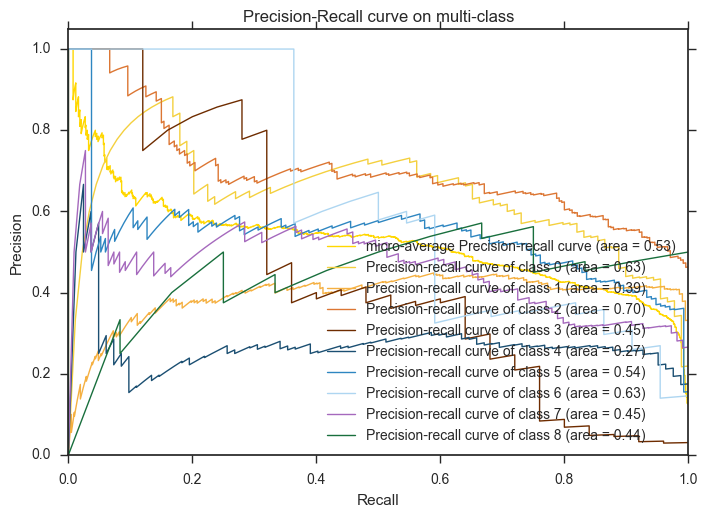

In [197]:
# Compute Precision-Recall and plot curve # Taken from SciKit-Learn
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_ts[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_ts[:, i], y_score[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_ts.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")

# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["micro"], precision["micro"], color='gold', lw=lw,
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve on multi-class')
plt.legend(loc="lower right")
plt.show()


## Refinement and paramater testing - Classification
Given these challenges feature engineering and parameter optimization will be undertaken to attempt to increase the score.

In [157]:
## Remove the well name
X= X.drop(["Well Name"],1)

## Feature engineering. All features have shown importance in PCA
## Take advantage of this by creating new features based on the relationships of key featuers.
## Make relationships between key features
X["DeltaPHI_PHIND"]=(X["DeltaPHI"]*X["PHIND"])
X["GR_PE"]=(X["GR"]*X["PE"])
X["PHIND_PE"]=(X["PHIND"]*X["PE"])
X["DeltaPHI_PE"]=(X["DeltaPHI"]*X["PE"])
X["ILD_log10_PE"]=(X["ILD_log10"]*X["PE"])
X["DeltaPHI_PHIND2"]=(X["DeltaPHI"]/X["PHIND"])
X["GR_ILD_log10"]=(X["GR"]*X["ILD_log10"])
X["M_PE"]=(X["NM_M"]*X["PE"])


Input_X = X

4149
11
    Depth     GR  ILD_log10  DeltaPHI   PHIND   PE  NM_M  RELPOS  \
0  2793.0  77.45      0.664       9.9  11.915  4.6     1   1.000   
1  2793.5  78.26      0.661      14.2  12.565  4.1     1   0.979   
2  2794.0  79.05      0.658      14.8  13.050  3.6     1   0.957   
3  2794.5  86.10      0.655      13.9  13.115  3.5     1   0.936   
4  2795.0  74.58      0.647      13.5  13.300  3.4     1   0.915   

   DeltaPHI_PHIND    GR_PE  PHIND_PE  DeltaPHI_PE  ILD_log10_PE  \
0        117.9585  356.270   54.8090        45.54        3.0544   
1        178.4230  320.866   51.5165        58.22        2.7101   
2        193.1400  284.580   46.9800        53.28        2.3688   
3        182.2985  301.350   45.9025        48.65        2.2925   
4        179.5500  253.572   45.2200        45.90        2.1998   

   DeltaPHI_PHIND2  GR_ILD_log10  M_PE  
0         0.830885      51.42680   4.6  
1         1.130123      51.72986   4.1  
2         1.134100      52.01490   3.6  
3         1.0598

### Choose X and y

In [26]:
## Input values for X
## == Input_X 
## Original input values for y
## == y_one_column
## One hot vector version of y
## == y
def X_y_inputs(X, y):
    X = X
    y = y
    return X, y

## Choose preprocessing

In [27]:
## Choose Scaler

## RobustScaler method
def select_scaler(Scaler_name):
    
    if Scaler_name == "Robust":
        from sklearn.preprocessing import RobustScaler
        Scaler = RobustScaler()
    
    elif Scaler_name == "Standard":
        from sklearn.preprocessing import StandardScaler
        Scaler = StandardScaler(with_mean=False)
    
    return Scaler


### Model selection

In [96]:
## Experiment and loop through different options to identify good models

## 1. how to import
## 2. name of model
## 3. tuned_parameter suggestions
## 4. scoring methods


def select_estimator(model_name):

    ## LogisticRegression
    elif model_name == "LogisticRegression":
        from sklearn.linear_model import LogisticRegression
        estimator = LogisticRegression()
        parameters = [{"C": [1000]}]
        from sklearn.metrics import mean_squared_error
        scores = ["recall_macro","f1_macro"]
    
    ## Random Forest
    elif model_name == "RandomForest":
        from sklearn.ensemble import RandomForestClassifier
        estimator = RandomForestClassifier()
        parameters = [{"n_estimators": [120, 300, 500, 1200], 
                       "max_depth": [5, 15, 30, None], 
                       "min_samples_split": [2, 10, 100], 
                       "min_samples_leaf":[1, 5, 10], 
                       "max_features":["log2", "sqrt", None]}]
        scores = ["f1_macro"]
    
    ## XGB
    elif model_name == "XGB":
        import xgboost as xgb
        estimator = xgb.XGBClassifier()
        parameters = [{ 
                       "gamma":[0.05, 0.1, 0.3, 0.5, 0.7], 
                       "max_depth":[3, 5, 7], 
                       "min_child_weight":[1], 
                       "subsample":[0.7], 
                       "colsample_bytree":[0.9]}]
        scores = ["f1_macro"]
    
    return estimator, parameters, scores


### Inner loop cross validation method

In [105]:
def inner_loop_cv(cv_name):

    n=6 # number of splits
    
    if cv_name == "KFold":
        from sklearn.model_selection import KFold
        cv = KFold(n_splits=n, shuffle=False)
    
    elif cv_name == "StratifiedKFold":
        from sklearn.model_selection import StratifiedKFold
        cv = StratifiedKFold(n_splits=n, shuffle=False)
    
    return cv

## Fit model on all parameter options 

In [126]:
def optimise_parameters(X, y, estimator, parameters, scores, cv):
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import classification_report
    Full_dict = {}
    best_result_list = []
    for score in scores:
        clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=cv,
                           scoring=score)
        
        ## Fit the model
        clf.fit(X, y)
        
        ## Store the best parameters
        result = clf.best_params_
        best_result_list.append(result)
        
        ## Capture all results data as a dataframe and store in a dictionary
        Full_dict[str(score)]=(pd.DataFrame(clf.cv_results_))
        
        ## Need to store the predict y from X_Test. 
        
        #y_true, y_pred = y, clf.predict(X)
        #b = classification_report(y_true, y_pred)
        #print(b)
        ### Need to strip away the last row to make this worka
        #frame = pd.DataFrame(b)
        #Score_dict[str(score)]=b
        
        print (clf.best_score_, ":", clf.best_params_)
        
    return best_result_list, Full_dict

## Run

Macro is choosen for score averaging because the data has skewed classed but the low population classes are as important as the higher population classes. It has previously been identified that recall is the biggest challange so that is also used for scoring to help identify good parameters.

In [150]:
## Select which model to run
Scaler_name ="Standard"
#Scaler_name = "Robust"
model_name = "LogisticRegression"
#model_name = "XGB"
#model_name = "RandomForest"
cv_name = "StratifiedKFold"


# 0.
X, y = X_y_inputs(Input_X, y_one_column)
# 1.
Scaler = select_scaler(Scaler_name)
X = Scaler.fit_transform(X)
# 2.
estimator, parameters, scores = select_estimator(model_name)
# 3.
cv = inner_loop_cv(cv_name)
# 4.
best_result_list, Full_dict = optimise_parameters(X, y, estimator, parameters, scores, cv)
# 5.
print (best_result_list)

## Check results quickly
#print (Full_dict)
c = Full_dict["f1_macro"]
c.head()

0.485839133752 : {'C': 1000}
0.478488534267 : {'C': 1000}
[{'C': 1000}, {'C': 1000}]


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split3_test_score,split3_train_score,split4_test_score,split4_train_score,split5_test_score,split5_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.909101,0.001529,0.478489,0.564877,1000,{'C': 1000},1,0.549649,0.55352,0.482997,...,0.403456,0.577381,0.442827,0.566102,0.502964,0.574168,0.176325,0.00018,0.046009,0.012918


0.807096639596


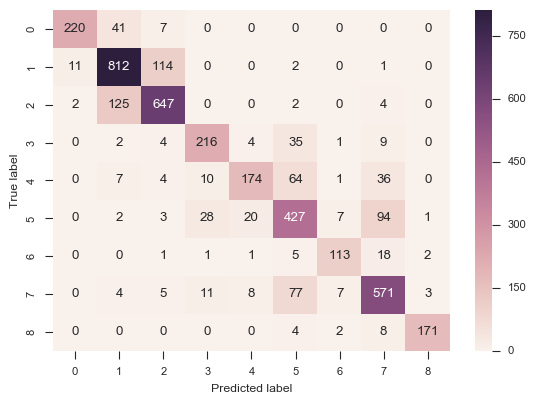

In [155]:
## Best results from investigations

## Extreme boosted trees

import xgboost as xgb
xgb_clf = xgb.XGBClassifier(gamma=0.05, subsample = 0.7, colsample_bytree = 0.9, min_child_weight = 1, max_depth = 3)

# 0.
X, y = X_y_inputs(Input_X, y_one_column)
# 1.
Scaler = select_scaler(Scaler_name)
X = Scaler.fit_transform(X)

xgb_clf.fit(X,y)
p_y=xgb_clf.predict(X)

from sklearn.metrics import f1_score
print (f1_score(y, p_y, average="weighted"))

from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y, p_y)
sns.heatmap(cnf_matrix, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Confusion Matrix

0.587409877402


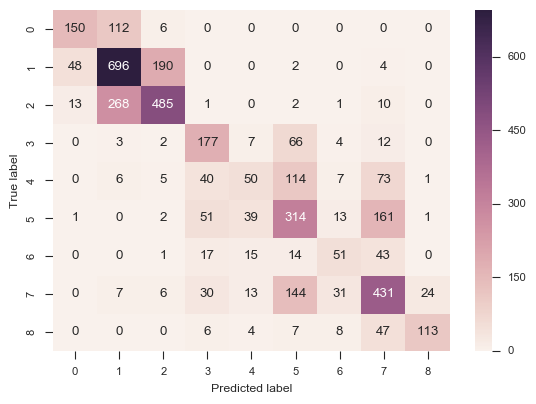

In [156]:
## Best results from investigations

## LogisticRegression

from sklearn.linear_model import LogisticRegression
logistic_clf = LogisticRegression(C=1000)

# 0.
X, y = X_y_inputs(Input_X, y_one_column)
# 1.
Scaler = select_scaler(Scaler_name)
X = Scaler.fit_transform(X)

logistic_clf.fit(X,y)
p_y=logistic_clf.predict(X)

from sklearn.metrics import f1_score
print (f1_score(y, p_y, average="weighted"))

from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y, p_y)
sns.heatmap(cnf_matrix, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')

The two confusion matrixes show the challenge with recall especially around non-marine coarse and fine siltstone. Ensemble based methods appear much better for mudstone and carbonate facies. There are still errors but the ensemble extreme boosted tree method appears better.

## Step 6: Reproducibility and result

Loading dataset...
Expected input is the file facies_vectors.csv
m=(4149,)
K=9
4149
11
   Well Name   Depth     GR  ILD_log10  DeltaPHI   PHIND   PE  NM_M  RELPOS
0  SHRIMPLIN  2793.0  77.45      0.664       9.9  11.915  4.6     1   1.000
1  SHRIMPLIN  2793.5  78.26      0.661      14.2  12.565  4.1     1   0.979
2  SHRIMPLIN  2794.0  79.05      0.658      14.8  13.050  3.6     1   0.957
3  SHRIMPLIN  2794.5  86.10      0.655      13.9  13.115  3.5     1   0.936
4  SHRIMPLIN  2795.0  74.58      0.647      13.5  13.300  3.4     1   0.915
       
Training F1 score: 0.807096639596


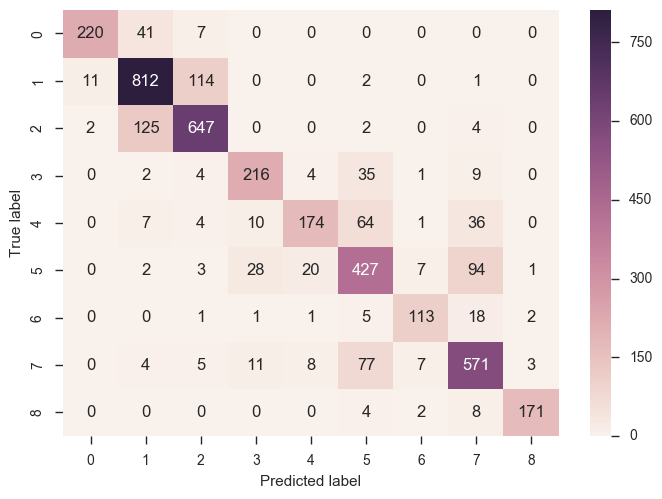

In [206]:
#     Load file
try:
    print("Loading dataset...")
    CSV_Dataset = r"facies_vectors.csv"
    Dataset = pd.read_csv(CSV_Dataset)
except:
    print ("An error has occured")
    print ("Please ensure that you have downloaded the dataset and")
    print ("entered the file location and file path for your machine")
finally:
    print ("Expected input is the file facies_vectors.csv")

Dataset.head()

## Replace all missing values with the mean values
Dataset = Dataset.fillna(Dataset.mean())

ytemp = Dataset.iloc[:,0] #Note 0 index is used in python for the first position. 
print (("m={0}").format(ytemp.shape))

## Keep the original version where all classifiers are stored in one columnn
y_one_column = ytemp


## Get all the elements of y
ySet = set(ytemp)
Yn = len(ySet)
print (("K={0}").format(Yn))

# One hot vector for each valye of y.
# Each classifier should have a sperate column and be measured only in ones and zeros
one_hot_y = ytemp
y = pd.get_dummies(one_hot_y)

y = y.rename(columns={1: "NM Coarse Sandstone", 2: "NM Coarse Siltstone", 3: "NM Fine Siltstone", 4:"Marine Siltstone", 5:"Mud Stone", 6:"Wacke Stone", 7:"Dolomite", 8:"Packe Stone", 9:"Baffle Stone"})

[Dm , Dn] = Dataset.shape
print (Dm)
print (Dn)
X = Dataset.iloc[:,1:Dn]  #where Dn is the number of columns in the original dataset
def prepare_X(X):
    ## List which features should be dropped from the training data
    Dropped_Features = ["Formation"]

    X = X.drop(Dropped_Features, 1)
    print (X.head())
    [Xm , Xn] = X.shape

    ## Merge together new class labels, y results as one hot vecotr and X
    df_full = pd.concat([new_classes, y, X], axis=1)
    df = pd.concat([new_classes, X], axis=1)

    ## Remove the well name
    X= X.drop(["Well Name"],1)

    ## Feature engineering. All features have shown importance in PCA
    ## Take advantage of this by creating new features based on the relationships of key featuers.
    ## Make relationships between key features
    X["DeltaPHI_PHIND"]=(X["DeltaPHI"]*X["PHIND"])
    X["GR_PE"]=(X["GR"]*X["PE"])
    X["PHIND_PE"]=(X["PHIND"]*X["PE"])
    X["DeltaPHI_PE"]=(X["DeltaPHI"]*X["PE"])
    X["ILD_log10_PE"]=(X["ILD_log10"]*X["PE"])
    X["DeltaPHI_PHIND2"]=(X["DeltaPHI"]/X["PHIND"])
    X["GR_ILD_log10"]=(X["GR"]*X["ILD_log10"])
    X["M_PE"]=(X["NM_M"]*X["PE"])


    Input_X = X
    return Input_X

Input_X = prepare_X(X)

def X_y_inputs(X, y):
    X = X
    y = y
    return X, y

def select_scaler(Scaler_name):
    
    if Scaler_name == "Robust":
        from sklearn.preprocessing import RobustScaler
        Scaler = RobustScaler()
    
    elif Scaler_name == "Standard":
        from sklearn.preprocessing import StandardScaler
        Scaler = StandardScaler(with_mean=False)
    
    return Scaler

## Best results from investigations

## Extreme boosted trees

import xgboost as xgb
xgb_clf = xgb.XGBClassifier(gamma=0.05, subsample = 0.7, colsample_bytree = 0.9, min_child_weight = 1, max_depth = 3)

# 0.
X, y = X_y_inputs(Input_X, y_one_column)
# 1.
Scaler = select_scaler(Scaler_name)
X = Scaler.fit_transform(X)

xgb_clf.fit(X,y)
p_y=xgb_clf.predict(X)

from sklearn.metrics import f1_score
print ("       ")
print ("Training F1 score:",f1_score(y, p_y, average="weighted"))

from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y, p_y)
sns.heatmap(cnf_matrix, annot=True, fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')

## Make prediction on test data

In [224]:
df_test = pd.read_csv('validation_data_nofacies.csv')
X_test = df_test

Input_X = prepare_X(X_test)
# 0.
X, y = X_y_inputs(Input_X, y_one_column)
# 1.
Scaler = select_scaler(Scaler_name)
X = Scaler.fit_transform(X)

p_y=xgb_clf.predict(X)

df_test_result=df_test
df_test_result["Predicted_y"]=p_y
df_test_result.head()
df_test_result.to_csv("ADMC_Prediction_XGB")

  Well Name   Depth      GR  ILD_log10  DeltaPHI  PHIND     PE  NM_M  RELPOS
0    STUART  2808.0  66.276      0.630       3.3  10.65  3.591     1   1.000
1    STUART  2808.5  77.252      0.585       6.5  11.95  3.341     1   0.978
2    STUART  2809.0  82.899      0.566       9.4  13.60  3.064     1   0.956
3    STUART  2809.5  80.671      0.593       9.5  13.25  2.977     1   0.933
4    STUART  2810.0  75.971      0.638       8.7  12.35  3.020     1   0.911


## Visualise results

In [219]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Predicted_y'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Predicted_y')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

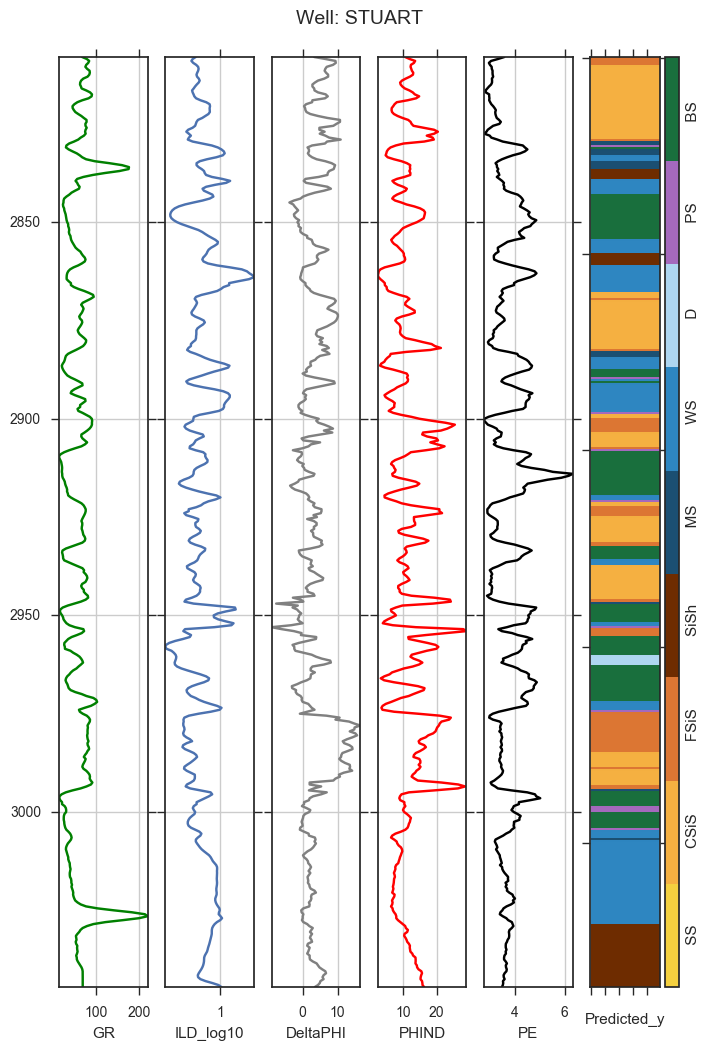

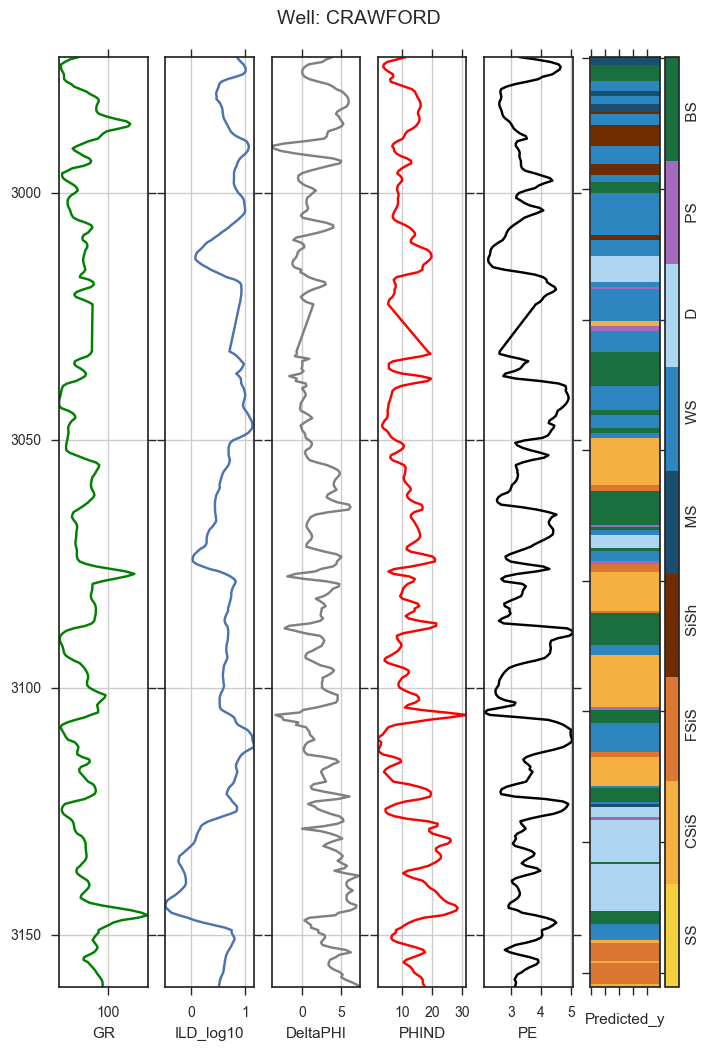

In [223]:
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl
make_facies_log_plot(
    df_test_result[df_test_result['Well Name'] == 'STUART'],
    facies_colors)

make_facies_log_plot(
    df_test_result[df_test_result['Well Name'] == 'CRAWFORD'],
    facies_colors)

## Recommendations

More feature engineering could be conducted. Some type of measure from when predicted facies have occured, the results appear to be highly variable suggeting a different relationship than seen in the original wells. Mainly relating to how quickly the system changes from marine to non-marine and backa again.

Great iniative, for future contests aim for an experimental design that will allow for a battle into the high 80s or 90s. With the right design this type of competition could really prove the potential of machine learning in geoscience. 